In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-white')
import dateutil
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
from schemdraw import flow, Drawing
import json

In [3]:
# Color scheme across plots
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

# qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
# qval_gtol = data['fdr corrected pval effect of glucose tolerance']
# qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

## Figure 1B: Blood glucose values RBG and FBG, averaged by tolerance 

## Figure 1B TODOs:
1. separate random-fed and fasted into two plots
    1. Use 2h OGTT number for week 12 RBG
2. Drop week 4
2. Include each animal's line, color by glucose tolerance

In [ ]:
def make_metadata_plot(data, xvals, xlabel, ylabel, offsets=[-0.12, 0, 0.12]): 
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    fig.set_facecolor('white')
    for gluc_tol, animals, offset in zip(['normal', 'impaired', 'diabetic'], 
                                         [normal, impaired, diabetic], 
                                         offsets):
        df = data.loc[animals]
        color = colors[gluc_tol]
        x = [xval + offset for xval in xvals]
        ax.errorbar(
            x, 
            df.mean(),
            yerr=df.std(), 
    #         capsize=4, capthick=2,
            fmt='-', linewidth=2, c=color, alpha=0.8, label=gluc_tol)
        for animal in animals:
            ax.scatter(x, df.loc[animal], color=color)
    plt.xticks(xvals, xvals, fontsize=18)
    plt.xlabel(xlabel, fontsize=20)
    plt.yticks(fontsize=16)
    ax.set_title(ylabel, fontsize=18, loc='left')
    plt.legend(loc=(1.01, 0.5), fontsize=17)
    sns.despine()
    return fig, ax

## RBG over weeks

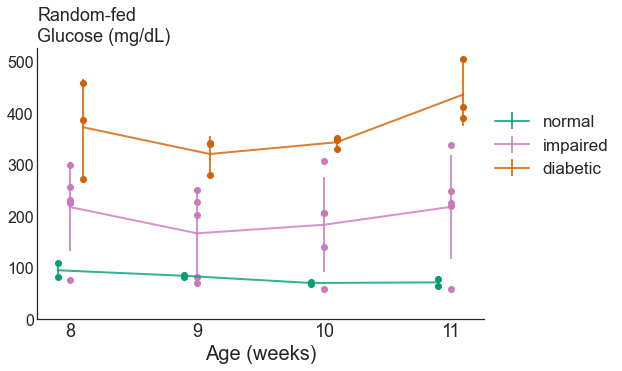

In [9]:
df = ap.loc[:, ap.filter(regex='^RBG').columns].iloc[:, 1:-1]
rbg_weeks_fig, rbg_weeks_ax = make_metadata_plot(df, [8,9,10,11], xlabel='Age (weeks)', 
                                   ylabel='Random-fed\nGlucose (mg/dL)', offsets=[-0.1, 0, 0.1])
plt.ylim(bottom=0)

plt.savefig(r'..\reports\figures\0-1-1\RBG_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\RBG_weeks.png', bbox_inches='tight')

## FBG over weeks

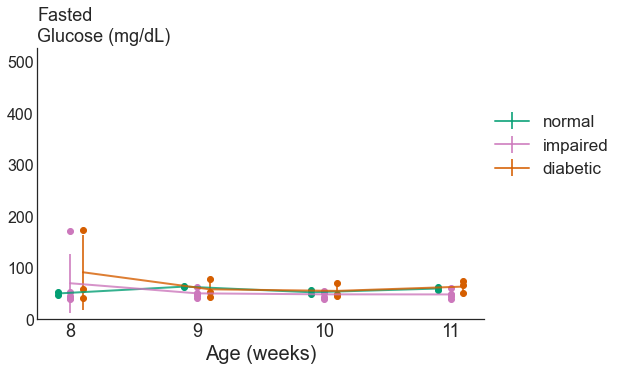

In [8]:
df = ap.loc[:, ap.filter(regex='^FBG').columns].iloc[:, :-1]
make_metadata_plot(df, [8,9,10,11], xlabel='Age (weeks)', ylabel='Fasted\nGlucose (mg/dL)', offsets=[-0.1, 0, 0.1])
plt.ylim(0, rbg_weeks_ax.get_ylim()[1])

plt.savefig(r'..\reports\figures\0-1-1\FBG_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\FBG_weeks.png', bbox_inches='tight')

# Figure 1C: Body weight averaged by glucose tolerance category
## Use non-fasted weights

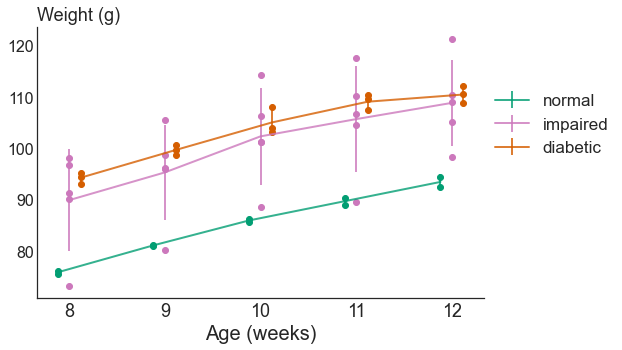

In [10]:
df = ap.loc[:, ap.filter(regex='Weightprefast').columns]
make_metadata_plot(df, [8,9,10,11,12], xlabel='Age (weeks)', ylabel='Weight (g)')

plt.savefig(r'..\reports\figures\0-1-1\weight_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\weight_weeks.png', bbox_inches='tight')

# Figure 1D
## Area under Curve of OGTT 

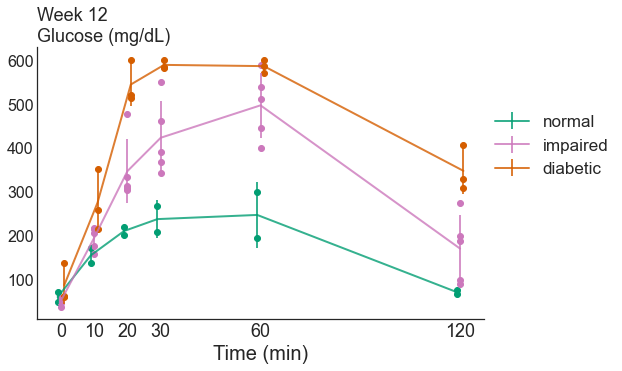

In [11]:
df = ap.loc[:, ap.filter(regex='OGTT\(').columns]
ogtt_fig, ogtt_ax = make_metadata_plot(df, [0,10,20,30,60,120], xlabel='Time (min)', 
                                       ylabel='Week 12\nGlucose (mg/dL)', offsets=[-1, 0, 1])

plt.savefig(r'..\reports\figures\0-1-1\OGTT_AUC.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\OGTT_AUC.png', bbox_inches='tight')

# Figure 1E
## Area under Curve of Insulin

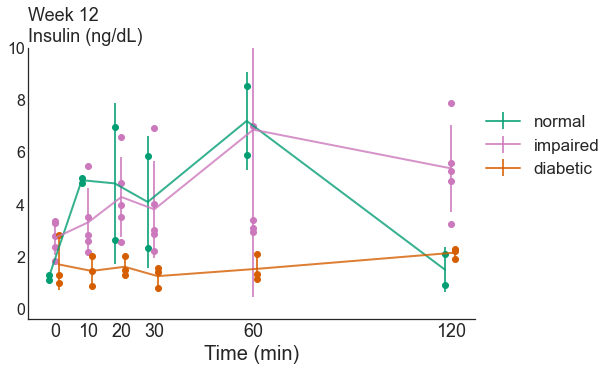

In [13]:
df = ap.loc[ap['lcms_sampled'], ap.filter(regex='Insulin\(').columns]
insulin_auc_fig, insulin_auc_ax = make_metadata_plot(df, [0,10,20,30,60,120], xlabel='Time (min)', 
                                       ylabel='Week 12\nInsulin (ng/dL)', offsets=[-2, 0, 1])
plt.ylim(top=10)

plt.savefig(r'..\reports\figures\0-1-1\insulin_AUC.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\insulin_AUC.png', bbox_inches='tight')

# Figure 1F: Insulin plots


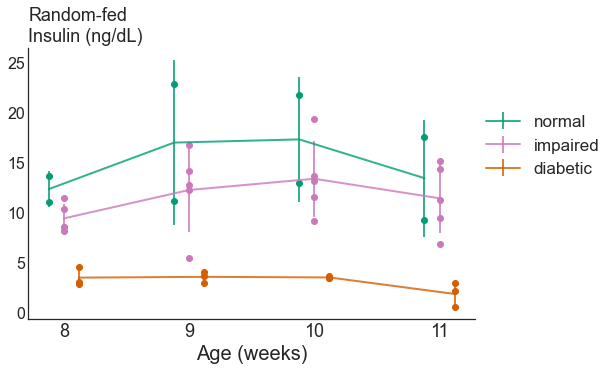

In [15]:
df = ap.loc[:,ap.filter(regex='InsulinRBG').columns].iloc[:, :-1]
make_metadata_plot(df, [8,9,10,11], xlabel='Age (weeks)', ylabel='Random-fed\nInsulin (ng/dL)')
rbg_insulin_ylim = plt.ylim()

plt.savefig(r'..\reports\figures\0-1-1\RBG_insulin_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\RBG_insulin_weeks.png', bbox_inches='tight')

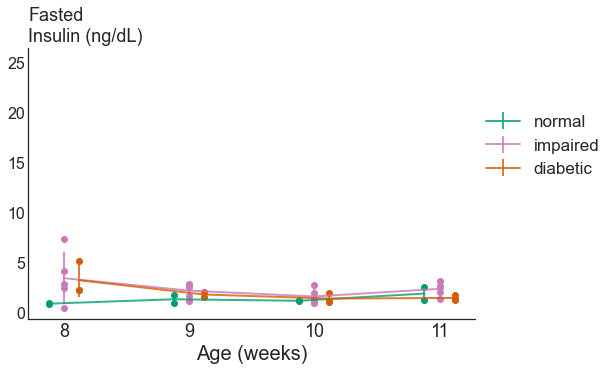

In [16]:
df = ap.loc[:,ap.filter(regex='InsulinFBG').columns].iloc[:, :-1]
make_metadata_plot(df, [8,9,10,11], xlabel='Age (weeks)', ylabel='Fasted\nInsulin (ng/dL)')
plt.ylim(rbg_insulin_ylim)

plt.savefig(r'..\reports\figures\0-1-1\FBG_insulin_weeks.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\FBG_insulin_weeks.png', bbox_inches='tight')

In [5]:
ap

,Date of birth,litter,lcms_sampled,glucose_tolerance,OGTT(0min),OGTT(10min),OGTT(20min),OGTT(30min),OGTT(60min),OGTT(120min),...,Weightprefastweek12,HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes
animal,,,,,,,,,,,,,,,,,,,,,
1060,2021-01-23,0,True,impaired,58.5,178.0,314.5,551.0,589.0,200.0,...,105.1,NaN,2.0448,1.945576,0.7185,0.683635,2.845929,murky,No,NaN
1061,2021-01-23,0,False,NaN,48.0,196.5,344.5,449.5,518.0,284.5,...,101.7,NaN,1.7808,1.751032,0.6059,0.595772,2.939099,murky,Slight,NaN
1062,2021-01-23,0,True,impaired,56.5,219.0,334.0,462.0,511.0,189.0,...,109.1,NaN,2.5185,2.308433,0.7439,0.681852,3.385536,murky,No,NaN
1063,2021-01-23,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,109.2,NaN,2.5485,2.333791,0.8614,0.788828,2.958556,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
1074,2021-01-23,0,True,impaired,38.5,160.0,308.0,368.0,445.5,99.0,...,110.4,NaN,2.5060,2.269928,0.7164,0.648913,3.498046,murky,Slight,NaN
1075,2021-01-23,0,False,NaN,169.0,355.0,600.0,600.0,569.5,392.0,...,105.5,NaN,1.3107,1.242370,0.5910,0.560190,2.217766,White,Yes,NaN
1076,2021-01-23,0,True,diabetic,138.0,352.5,513.5,585.0,600.0,406.5,...,112.1,NaN,1.4332,1.278501,0.6960,0.620874,2.059195,White,Slight,NaN
1080,2021-01-24,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112.1,NaN,1.9369,1.727832,0.7754,0.691704,2.497937,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
1081,2021-01-24,1,False,NaN,171.0,345.0,547.0,600.0,563.0,428.5,...,113.2,NaN,1.3511,1.193551,0.6283,0.555035,2.150406,White,No,NaN


In [9]:
ap.loc[ap['lcms_sampled'], ap.filter(regex='OGTT\(').columns].loc[animal]

OGTT(0min)       72.0
OGTT(10min)     172.5
OGTT(20min)     201.5
OGTT(30min)     208.0
OGTT(60min)     195.0
OGTT(120min)     67.5
Name: 1091, dtype: float64

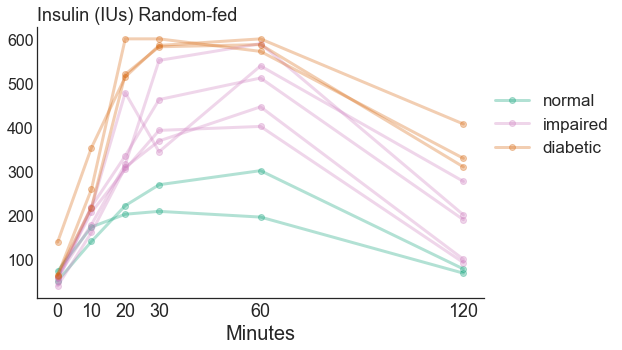

In [15]:
x = [0, 10, 20, 30, 60, 120]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for animal in animals_used:
    df = ap.loc[ap['lcms_sampled'], ap.filter(regex='OGTT\(').columns].loc[animal]
    gluc_tol = animal_tol[animal]
    color = colors[gluc_tol]
    ax.plot(x, df, 'o-', c=color, linewidth=3, label=gluc_tol, alpha=0.3)
#     ax.errorbar(x, df, yerr=2)
plt.xticks(x, x, fontsize=18)
plt.xlabel('Minutes', fontsize=20)
plt.yticks(fontsize=16)
# ax.set_ylabel('Insulin (IUs)', fontsize=20, loc='top')
ax.set_title('Insulin (IUs) Random-fed', fontsize=18, loc='left')
# fig.suptitle('Insulin (Random-fed)', fontsize=22)

h, l = ax.get_legend_handles_labels()
handles = [h[0], h[2], h[-1]]
labels = [l[0], l[2], l[-1]]
plt.legend(handles, labels, loc=(1.01, 0.5), fontsize=17)
sns.despine()

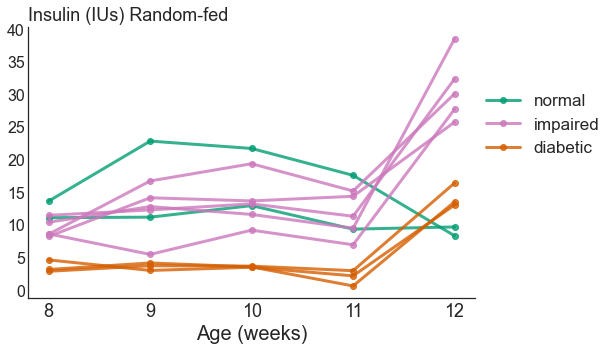

In [4]:
x = [8, 9, 10, 11, 12]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

for animal in animals_used:
    df = ap.loc[ap['lcms_sampled'], ap.filter(regex='InsulinRBG').columns].loc[animal]
    gluc_tol = animal_tol[animal]
    color = colors[gluc_tol]
    ax.plot(x, df, 'o-', c=color, linewidth=3, label=gluc_tol, alpha=0.8)
#     ax.errorbar(x, df, yerr=2)
plt.xticks(x, x, fontsize=18)
plt.xlabel('Age (weeks)', fontsize=20)
plt.yticks(fontsize=16)
# ax.set_ylabel('Insulin (IUs)', fontsize=20, loc='top')
ax.set_title('Insulin (IUs) Random-fed', fontsize=18, loc='left')
# fig.suptitle('Insulin (Random-fed)', fontsize=22)

h, l = ax.get_legend_handles_labels()
handles = [h[0], h[2], h[-1]]
labels = [l[0], l[2], l[-1]]
plt.legend(handles, labels, loc=(1.01, 0.5), fontsize=17)
sns.despine()

# Figure 1F: OGTT vs Insulin plot with best fit line

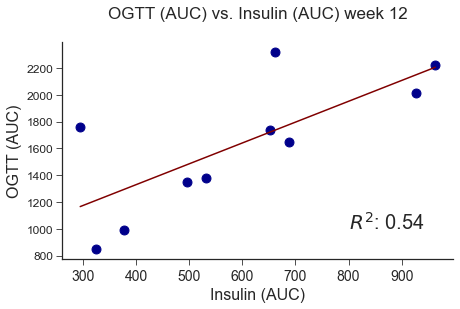

In [335]:
ogtt_vs_insulin = ap.loc[ap['lcms_sampled']]
ogtt_insulin_regres = LinearRegression().fit(ogtt_vs_insulin['Insulin (AUC)'].values.reshape(-1, 1), 
                                             ogtt_vs_insulin['OGTT (AUC)'].values.reshape(-1, 1))
ovi_slope = ogtt_insulin_regres.coef_.item()
ovi_intercept = ogtt_insulin_regres.intercept_.item()
ovi_r2 = ogtt_insulin_regres.score(ogtt_vs_insulin['Insulin (AUC)'].values.reshape(-1, 1),
                                   ogtt_vs_insulin['OGTT (AUC)'].values.reshape(-1, 1))
ovi_r2

min_insulin = min(ogtt_vs_insulin['Insulin (AUC)'])
max_insulin = max(ogtt_vs_insulin['Insulin (AUC)'])

plt.plot(
    [min_insulin, max_insulin], 
    [ovi_intercept + min_insulin*ovi_slope, ovi_intercept + max_insulin*ovi_slope],
    c='maroon'
)
plt.scatter(
    ogtt_vs_insulin['Insulin (AUC)'], 
    ogtt_vs_insulin['OGTT (AUC)'], 
    s=80, 
    c='darkblue')
plt.annotate('$R^2$: ' + str(round(ovi_r2, 2)), xy=(800, 1000), fontsize=20)
plt.xlabel('Insulin (AUC)', fontsize=16)
plt.ylabel('OGTT (AUC)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
sns.despine()
plt.title('OGTT (AUC) vs. Insulin (AUC) week 12\n', fontsize=17)
plt.gcf().set_size_inches(7, 4)

### The normal/impaired/diabetic classification came from the oral glucose test (OGTT) 

The OGTT area under curve (AUC) gives the integration of the OGTT blood glucose test based on the time points between 0 and 120 minutes 

### Use a K-means clustering method to derive cut-off values for k groups of glucose tolerance 

Because K-means uses a distance metric, it is suggested to use Standardized data. However, based on the shape of the graphs below elbow plots below, it doesn't make a difference as to the number of clusters. 

[[1761.75]
 [1674.8 ]
 [1648.75]
 [1350.25]
 [3365.  ]
 [2321.25]
 [2354.75]
 [2224.75]
 [ 846.75]
 [1377.95]
 [ 993.  ]
 [ 842.75]
 [1401.25]
 [2015.75]
 [1738.25]]


Text(0.5, 1.0, 'Elbow plot of K-means clusters')

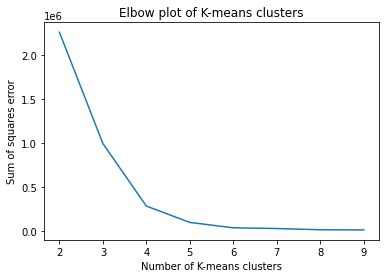

In [129]:
ogtt_auc = np.array(animal_phenotypes.loc[animal_phenotypes['OGTT (AUC)'].notna(), 'OGTT (AUC)']).reshape(-1, 1)
print(ogtt_auc)
ss_errors = []
ss_errors_scaled = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init='random', random_state=1000)
    kmeans.fit(ogtt_auc)
    ss_errors.append(kmeans.inertia_)
    
    kmeans_scaled = KMeans(n_clusters=k, init='random', random_state=1000)
    kmeans_scaled.fit(StandardScaler().fit_transform(ogtt_auc))
    ss_errors_scaled.append(kmeans_scaled.inertia_)

plt.plot(range(2, 10), ss_errors)
plt.ylabel('Sum of squares error')
plt.xlabel('Number of K-means clusters')
plt.title('Elbow plot of K-means clusters')

# plt.figure()
# plt.plot(range(2, 10), ss_errors_scaled)

In [46]:
ogtt_auc.reshape(-1)

array([1761.75, 1674.8 , 1648.75, 1350.25, 3365.  , 2321.25, 2354.75,
       2224.75,  846.75, 1377.95,  993.  ,  842.75, 1401.25, 2015.75,
       1738.25])

In [37]:
ogtt_auc_animals_used = ap.loc[ap.index.isin(animals_used), 'OGTT (AUC)']
ogtt_auc_animals_used

animal
1060    1761.75
1062    1648.75
1074    1350.25
1076    2321.25
1082    2224.75
1091     846.75
1092    1377.95
1093     993.00
1101    2015.75
1102    1738.25
Name: OGTT (AUC), dtype: float64

In [38]:
ogtt_auc_animals_not_used = ap.loc[~ap.index.isin(animals_used), 'OGTT (AUC)'].dropna()
ogtt_auc_animals_not_used

animal
1061    1674.80
1075    3365.00
1081    2354.75
1094     842.75
1096    1401.25
Name: OGTT (AUC), dtype: float64

In [39]:
ogtts = ap.loc[ap['OGTT (AUC)'].notna(), 'OGTT (AUC)']
ogtt_auc = ogtts.values.reshape(-1, 1)

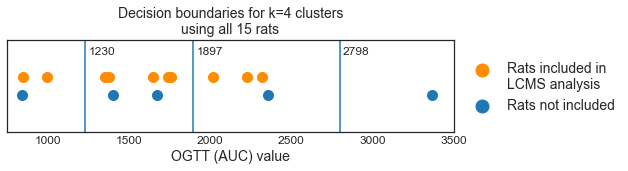

In [63]:
# Plot OGTT AUC data on 1-D plot, with decision boundaries

test_data = np.arange(3500).reshape(-1, 1)

# kmeans_2 = KMeans(n_clusters=2, init='random', random_state=1000)
# kmeans_2.fit(ogtt_auc)

# plt.gcf().set_size_inches((7, 2))
# plt.scatter(ogtt_auc.reshape(-1), [0]*15)
# plt.xlim((750, 3500))
# plt.ylim((-0.01, 0.01))
# k2_pred = list(kmeans_2.predict(test_data))
# # From the test data, get the .index of the first instance of each cluster, giving the boundary line
# for index in range(0, 2):
#     plt.vlines(k2_pred.index(index), ymin=-1, ymax=1)
# plt.yticks([])
# plt.xlabel('OGTT (AUC) value')
# plt.title('Decision boundaries for k=2 clusters\nusing all 15 rats')


# kmeans_3 = KMeans(n_clusters=3, init='random', random_state=1000)
# kmeans_3.fit(ogtt_auc)
# plt.figure()
# plt.gcf().set_size_inches((7, 2))
# plt.scatter(ogtt_auc.reshape(-1), [0]*15)
# plt.xlim((700, 3500))
# plt.ylim((-0.01, 0.01))
# k3_pred = list(kmeans_3.predict(test_data))
# # From the test data, get the .index of the first instance of each cluster, giving the boundary line
# for index in range(0, 3):
#     plt.vlines(k3_pred.index(index), ymin=-1, ymax=1)
# plt.yticks([])
# plt.xlabel('OGTT (AUC) value')
# plt.title('Decision boundaries for k=3 clusters\nusing all 15 rats')


kmeans_4 = KMeans(n_clusters=4, init='random', random_state=1000)
kmeans_4.fit(ogtt_auc)
plt.figure()
plt.gcf().set_size_inches((8, 1.7))
plt.scatter(ogtt_auc_animals_used, [0.2]*10, s=100, c='darkorange', label='\nRats included in\nLCMS analysis')
plt.scatter(ogtt_auc_animals_not_used, [-0.2]*5, s=100, label='Rats not included')
plt.xlim((750, 3500))
plt.ylim((-1, 1))
k4_pred = list(kmeans_4.predict(test_data))
# From the test data, get the .index of the first instance of each cluster, giving the boundary line
for index in range(1, 4):
    plt.vlines(k4_pred.index(index), ymin=-1, ymax=1)
    plt.annotate(str(k4_pred.index(index)), xy=(k4_pred.index(index)+20, 0.69), fontsize=12)
plt.yticks([])
plt.xlabel('OGTT (AUC) value', fontsize=14)
plt.xticks(fontsize=12)
plt.title('Decision boundaries for k=4 clusters\nusing all 15 rats', fontsize=14)
plt.legend(loc=(1.02, 0.15), fontsize=14, markerscale=1.3)

plt.savefig(r'..\reports\figures\0-1-1\glucose_tolerance_decision_boundaries.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\0-1-1\glucose_tolerance_decision_boundaries.png', bbox_inches='tight')

Text(0.5, 1.0, 'Decision boundaries for k=4 clusters\nusing all 15 rats')

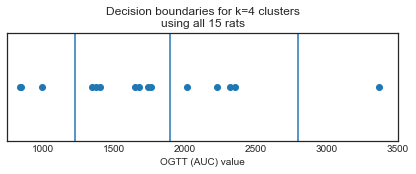

In [49]:
kmeans_4 = KMeans(n_clusters=4, init='random', random_state=1000)
kmeans_4.fit(ogtt_auc)

plt.gcf().set_size_inches((7, 2))
plt.scatter(ogtt_auc, [0]*15)
plt.xlim((750, 3500))
plt.ylim((-0.01, 0.01))
k4_pred = list(kmeans_4.predict(test_data))
# From the test data, get the .index of the first instance of each cluster, giving the boundary line
for index in range(1, 4):
    plt.vlines(k4_pred.index(index), ymin=-1, ymax=1)
plt.yticks([])
plt.xlabel('OGTT (AUC) value')
plt.title('Decision boundaries for k=4 clusters\nusing all 15 rats')

In [50]:
# pt = phenotypes of animals sampled for LCMS
pt = ap[ap.index.isin(animals_used)].sort_values('glucose_tolerance')
pt

,Date of birth,litter,lcms_sampled,glucose_tolerance,OGTT(0min),OGTT(10min),OGTT(20min),OGTT(30min),OGTT(60min),OGTT(120min),...,Weightprefastweek12,HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes
animal,,,,,,,,,,,,,,,,,,,,,
1076,2021-01-23,0,True,diabetic,138.0,352.5,513.5,585.0,600.0,406.5,...,112.1,NaN,1.4332,1.278501,0.6960,0.620874,2.059195,White,Slight,NaN
1082,2021-01-24,1,True,diabetic,62.0,258.0,600.0,600.0,571.5,328.5,...,108.8,NaN,0.8904,0.818382,0.6515,0.598805,1.366692,White,Yes,NaN
1101,2021-02-01,3,True,diabetic,64.5,216.5,519.5,582.0,587.0,309.0,...,110.5,NaN,0.9262,0.838190,0.6216,0.562534,1.490026,murky,Yes definitely,NaN
1060,2021-01-23,0,True,impaired,58.5,178.0,314.5,551.0,589.0,200.0,...,105.1,NaN,2.0448,1.945576,0.7185,0.683635,2.845929,murky,No,NaN
1062,2021-01-23,0,True,impaired,56.5,219.0,334.0,462.0,511.0,189.0,...,109.1,NaN,2.5185,2.308433,0.7439,0.681852,3.385536,murky,No,NaN
1074,2021-01-23,0,True,impaired,38.5,160.0,308.0,368.0,445.5,99.0,...,110.4,NaN,2.5060,2.269928,0.7164,0.648913,3.498046,murky,Slight,NaN
1092,2021-01-31,2,True,impaired,59.5,206.0,303.5,392.0,401.0,91.5,...,98.3,NaN,1.2902,1.312513,0.6312,0.642116,2.044043,clear,Slight,NaN
1102,2021-02-01,3,True,impaired,48.5,216.5,477.5,343.5,538.5,276.0,...,121.3,NaN,1.7053,1.405853,0.8780,0.723825,1.942255,murky,Very slight,NaN
1091,2021-01-31,2,True,normal,72.0,172.5,201.5,208.0,195.0,67.5,...,92.4,NaN,1.4930,1.615801,0.5354,0.579437,2.788569,clear,Slight,NaN


In [20]:
plt.scatter(pt['glucose_tolerance'], pt['OGTT (AUC)'])
plt.title('Oral glucose test Area Under Curve (AUC) per glucose tolerance')
plt.ylabel('AUC')

NameError: name 'pt' is not defined

In [21]:
plt.scatter(pt['Date of birth'], pt['OGTT (AUC)'])
plt.xticks(rotation=90)
plt.xlabel('Rat date of birth')
plt.ylabel('OGTT AUC')
plt.title('OGTT result by rat date of birth')# \n(Includes rats not sampled for LC-MS)')

NameError: name 'pt' is not defined

<AxesSubplot:xlabel='datetime'>

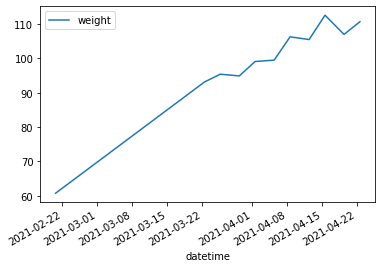

In [147]:
obs_used[(obs_used['weight type'] == 'Weight') & (obs_used['animal'] == 1076)][['datetime', 'weight']].plot('datetime', 'weight')

<AxesSubplot:xlabel='datetime'>

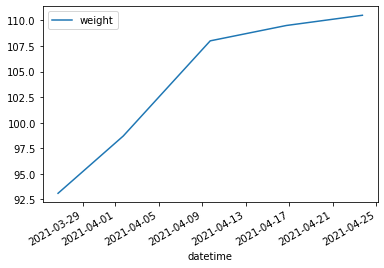

In [148]:
obs_used[(obs_used['weight type'] == 'Weight (pre-fasting)') & (obs_used['animal'] == 1101)][['datetime', 'weight']].plot('datetime', 'weight')

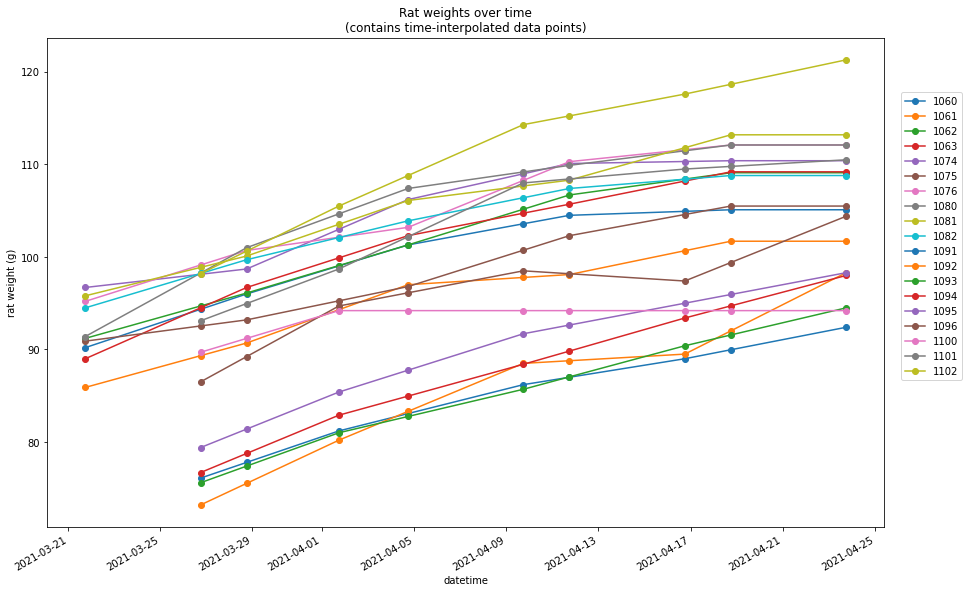

In [151]:
obs_used[(obs_used['weight type'] == 'Weight (pre-fasting)') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'weight', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='weight')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 10)
plt.ylabel('rat weight (g)')
plt.title('Rat weights over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.02, 0.3))

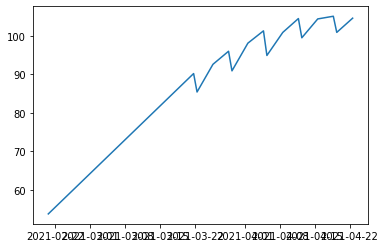

In [58]:
obs_used[obs_used['animal'] == 1060][['datetime', 'weight']]

plt.plot(obs_used[obs_used['animal'] == 1060][['datetime',]], obs_used[obs_used['animal'] == 1060][['weight']])

# OLD FIGURES 

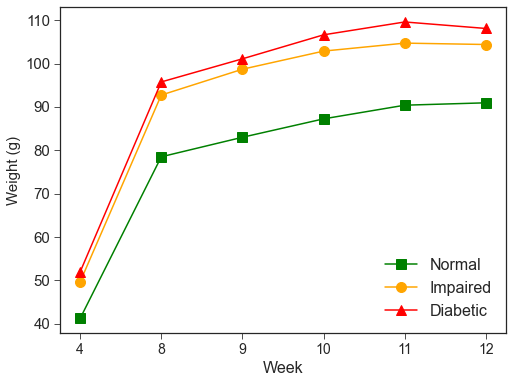

In [13]:
weight = obs.loc[(obs['weight type'] == 'Weight') & \
                  ((obs['BG type'] == 'RBG') | (obs['BG type'] == 'Post-OGTT BG'))] 
nweight = weight.loc[weight['animal'].isin(normal)].groupby('week').mean()['weight']
iweight = weight.loc[weight['animal'].isin(impaired)].groupby('week').mean()['weight']
dweight = weight.loc[weight['animal'].isin(diabetic)].groupby('week').mean()['weight']
nweight

weight_weeks = ['4','8','9','10','11','12']
plt.plot(weight_weeks, nweight, 's-',  label='Normal',   ms=10, c='green')
plt.plot(weight_weeks, iweight, 'o-',  label='Impaired', ms=10, c='orange')
plt.plot(weight_weeks, dweight, '^-',  label='Diabetic', ms=10, c='red')

plt.legend(fontsize=16)
plt.gcf().set_size_inches((8, 6))
plt.xticks(ticks=[0,1,2,3,4,5,], fontsize=14)
plt.xlabel('Week', fontsize=16)
plt.yticks(fontsize=15)
plt.ylabel('Weight (g)', fontsize=15)

ax2 = plt.gca()
# plt.plot(rbg_weeks, normal_rbgs  ,   's-',  label='Random-fed\nnormal',   ms=10, c='green',  )
# plt.plot(fbg_weeks, normal_fbgs  ,   'o--', label='Fasted\nnormal',       ms=10, c='green',  )
# plt.plot(rbg_weeks, impaired_rbgs, 's-',  label='Random-fed\nimpaired', ms=10, c='orange', )
# print('')

## Combine Fig 1B and 1C into one 

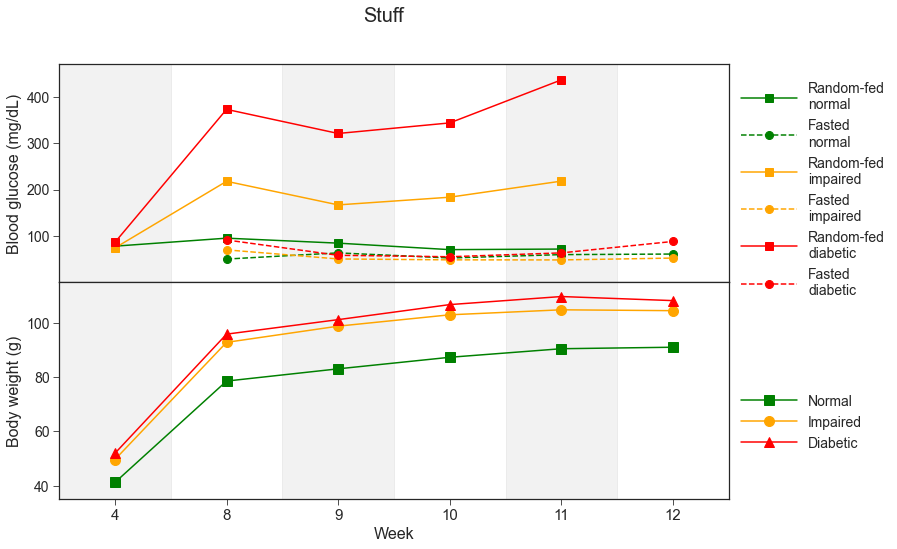

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.subplots_adjust(hspace=0.00)
# fig.xlim((0,10))
fig.set_size_inches((12, 8))
fig.suptitle('Stuff', fontsize=20)
# fig.supylabel('')
# plt.yticks(fontsize=15)

ax[0].plot(rbg_weeks, normal_rbgs  ,   's-',  label='Random-fed\nnormal',   ms=8, c='green',  )
ax[0].plot(fbg_weeks, normal_fbgs  ,   'o--', label='Fasted\nnormal',       ms=8, c='green',  )
ax[0].plot(rbg_weeks, impaired_rbgs,   's-',  label='Random-fed\nimpaired', ms=8, c='orange', )
ax[0].plot(fbg_weeks, impaired_fbgs,   'o--', label='Fasted\nimpaired',     ms=8, c='orange', )
ax[0].plot(rbg_weeks, diabetic_rbgs,   's-',  label='Random-fed\ndiabetic', ms=8, c='red',    )
ax[0].plot(fbg_weeks, diabetic_fbgs,   'o--', label='Fasted\ndiabetic',     ms=8, c='red',    )
ax[0].legend(loc=(1.01, -0.1), fontsize=14, handlelength=4)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_ylabel('Blood glucose (mg/dL)', fontsize=16)
ax[0].set_ylim(1, 470)

# ax[0].set_xticks(ticks=[0,1,2,3,4,5])
# ax[0].set_xticklabels(labels=['4','8','9','10','11','12'])

ax[1].plot(weight_weeks, nweight, 's-',  label='Normal',   ms=10, c='green')
ax[1].plot(weight_weeks, iweight, 'o-',  label='Impaired', ms=10, c='orange')
ax[1].plot(weight_weeks, dweight, '^-',  label='Diabetic', ms=10, c='red')
ax[1].set_ylabel('Body weight (g)', fontsize=16)
ax[1].legend(loc=(1.01, 0.2), fontsize=14, handlelength=4)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].set_ylim(35, 115)

# Make nice gray backgrounds:
# for a in ax:
#     for i1, i2 in zip(np.arange(-0.5, 4.5, 2), np.arange(0.5, 5.5, 2)):
#         a.axvspan(i1, i2, color='gray', alpha=0.1)

plt.xticks(fontsize=15)
plt.xlabel('Week', fontsize=16)
plt.xlim(-0.5, 5.5)

plt.savefig(r'..\reports\figures\0-1-1\combined_metadata.svg')

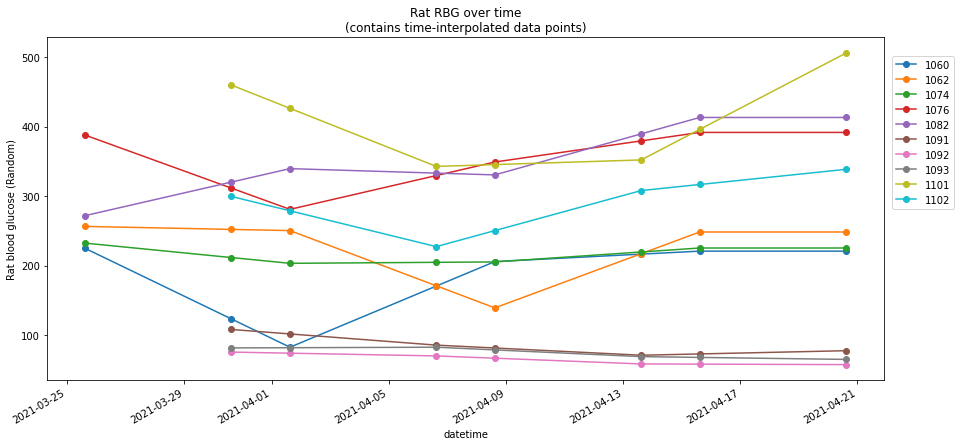

In [140]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .dropna(axis=0, how='all')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 7)
plt.ylabel('Rat blood glucose (Random)')
plt.title('Rat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

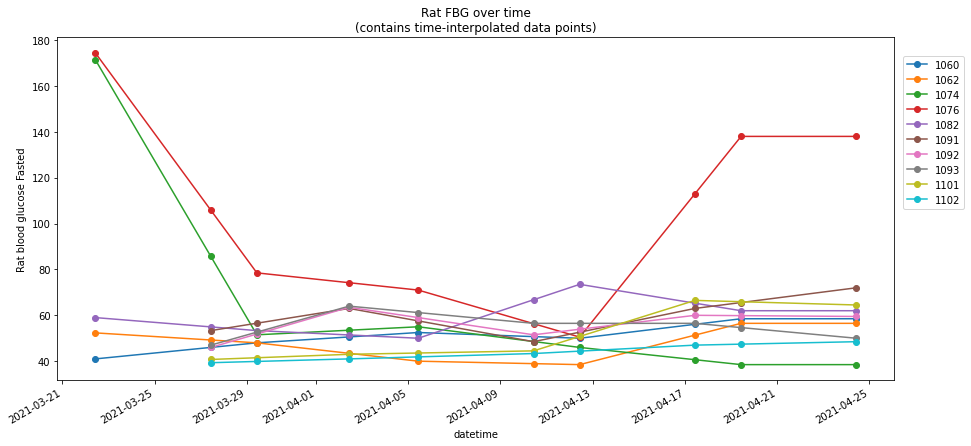

In [160]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 7)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Rat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

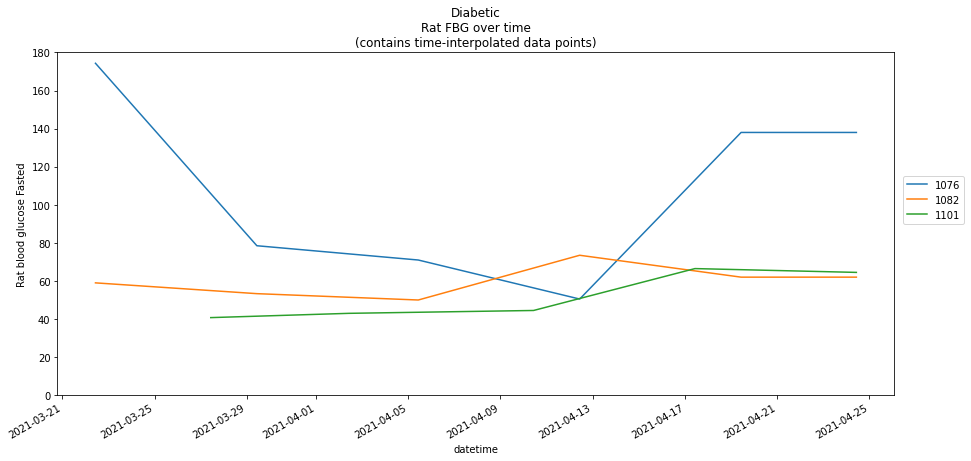

In [167]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(diabetic)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Diabetic\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

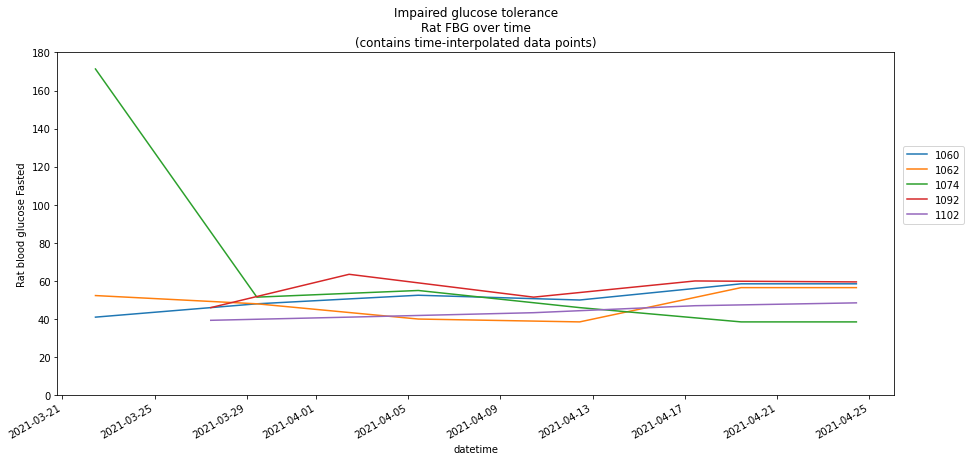

In [168]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(impaired)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Impaired glucose tolerance\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

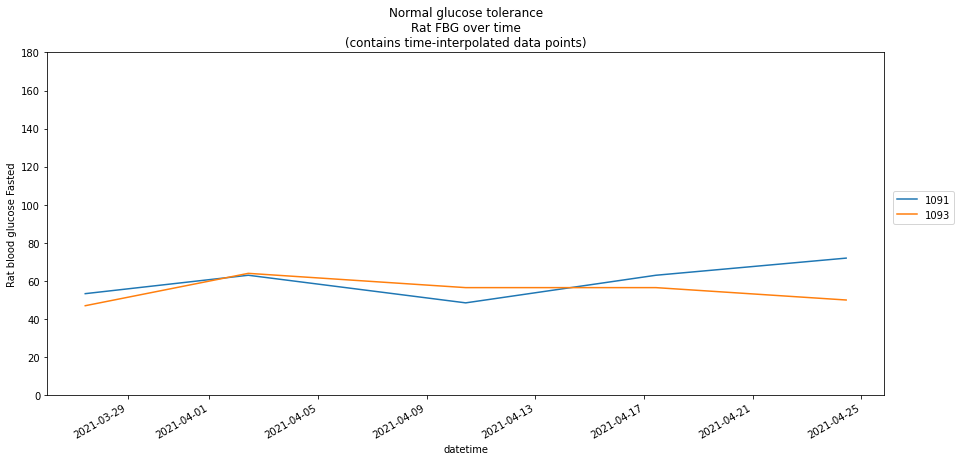

In [169]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(normal)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Normal glucose tolerance\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

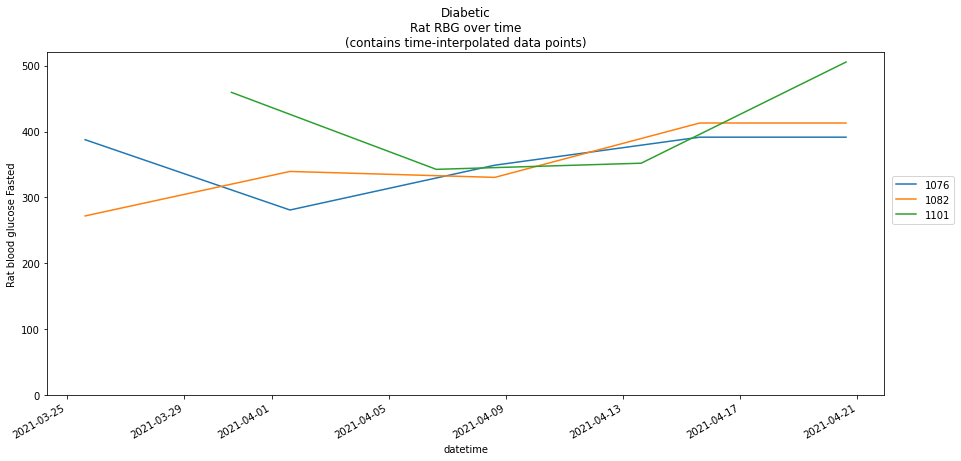

In [183]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(diabetic)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Diabetic\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

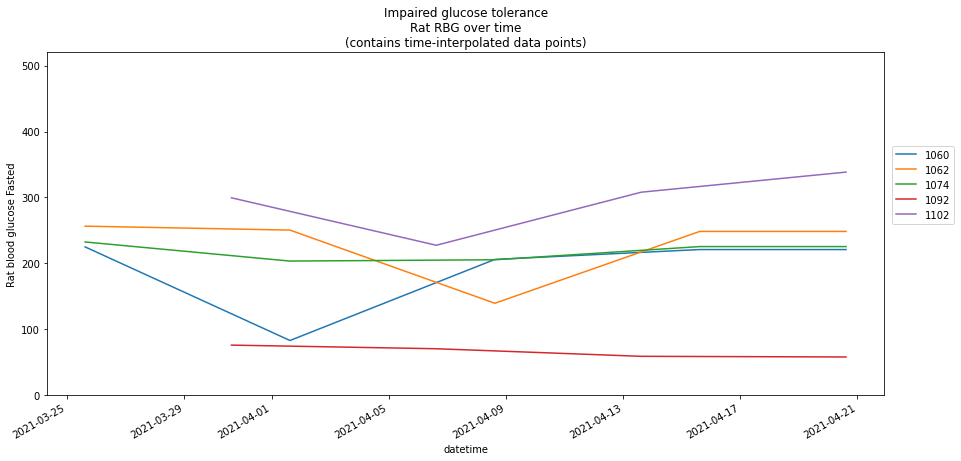

In [184]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(impaired)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Impaired glucose tolerance\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

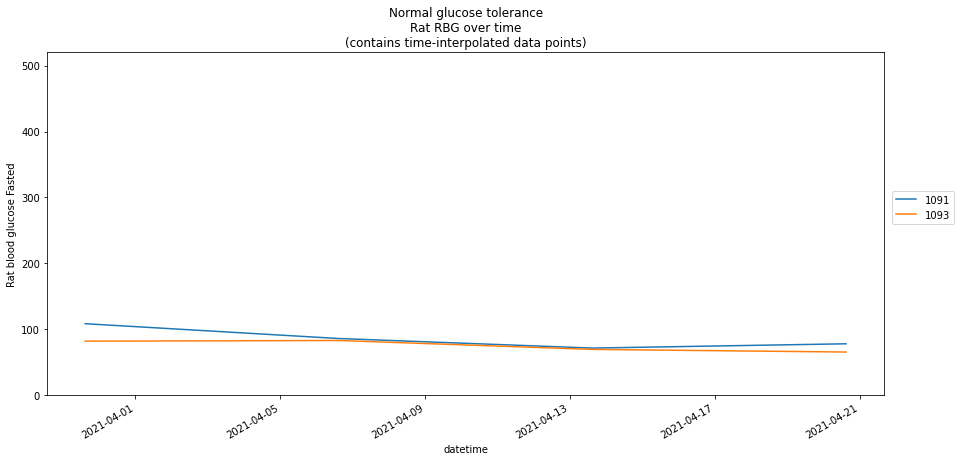

In [185]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(normal)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Normal glucose tolerance\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

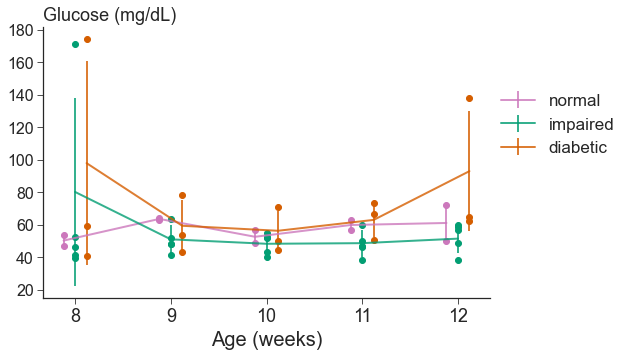

In [285]:
weeks = [8, 9, 10, 11, 12]
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
for gluc_tol, animals, offset in zip(['normal', 'impaired', 'diabetic'], 
                                     [normal, impaired, diabetic], 
                                     [-0.12, 0, 0.12]):
    df = ap.loc[animals, ap.filter(regex='^FBG').columns]
    for col in df:
        df.loc['min', col], df.loc['max', col] = min(df[col]), max(df[col])  # get max and min of each column in rows
    df.loc['mean'] = df.mean()
    color = colors[gluc_tol]
    xvals = [x + offset for x in weeks]
    ax.errorbar(
        xvals, 
        df.loc['mean'],
        yerr=df.std(),
#         yerr=abs(df.loc[['min', 'max']] - df.loc['mean']).values, # Important! Errors must be abs(+/-) from center
        linewidth=2, 
#         capsize=4, capthick=2,
        fmt='-', 
        c=color, alpha=0.8, label=gluc_tol)
    for animal in animals:
        ax.scatter(xvals, df.loc[animal], color=color)
plt.xticks(weeks, weeks, fontsize=18)
plt.xlabel('Age (weeks)', fontsize=20)
plt.yticks(fontsize=16)
ax.set_title('Glucose (mg/dL)', fontsize=18, loc='left')
plt.legend(loc=(1.01, 0.5), fontsize=17)
sns.despine()

In [270]:
ogtt = ap.loc[ap['animal'].isin(animals_used)].filter(regex='OGTT|animal').set_index('animal').iloc[:, :-1]
# ogtt = ap.filter(regex='OGTT|animal').set_index('animal').iloc[:, :-1]
nogtt = ogtt.loc[ogtt.index.isin(normal)]
iogtt = ogtt.loc[ogtt.index.isin(impaired)]
dogtt = ogtt.loc[ogtt.index.isin(diabetic)]

fig, ax = plt.subplots()
fig.set_size_inches((8, 5))

xnorm = [10, 20, 30, 60, 120]
xlabels = ['10', '\n20', '30', '60', '120']
ximp = [x + 160 for x in xnorm]
xdia = [x + 320 for x in xnorm]
for df, tol in zip([nogtt, iogtt, dogtt], ['n', 'i', 'd']):
    for i, row in df.iterrows():
        if tol == 'n':
            x = xnorm
        elif tol == 'i':
            x = ximp
        else:
            x = xdia
        plt.plot(x, row, '.-', alpha=0.6, lw=2.5, ms=10)
        # make an array of points in a line that connect start point to end point
#         plt.fill_between(x, y1=row, y2=0, alpha=0.1)

plt.ylabel('Blood glucose (mg/dL)', fontsize=16)
plt.yticks(fontsize=15)
plt.ylim(25, 620)
plt.xticks(ticks=(xnorm+ximp+xdia), labels=xlabels*3, fontsize=15);
plt.xlabel('Time (min)', fontsize=16)
plt.xlim(-10, 460)
# ax.axvspan(-10, 150, color='green', alpha=0.04, label='Normal')
# ax.axvspan(150, 300, color='orange', alpha=0.04, label='Impaired')
# ax.axvspan(300, 460, color='red', alpha=0.04, label='Diabetic')

# handles, labels = ax.get_legend_handles_labels()
# handles = [handle.set_fill('black') for handle in handles]
# ax.legend(loc=(1.01, 0.5), fontsize=15)
plt.annotate('Normal\nn=2',   (60,  50), fontsize=15, ha='center')
plt.annotate('Impaired\nn=5', (225, 50), fontsize=15, ha='center')
plt.annotate('Diabetic\nn=3', (380, 50), fontsize=15, ha='center')
plt.title('OGTT Test Results', fontsize=20)

# plt.savefig(r'..\reports\figures\0-1-1\OGTT_AUCs.svg')

KeyError: 'animal'

Text(0.5, 1.0, 'Blood glucose measurements\nMean of diabetic status')

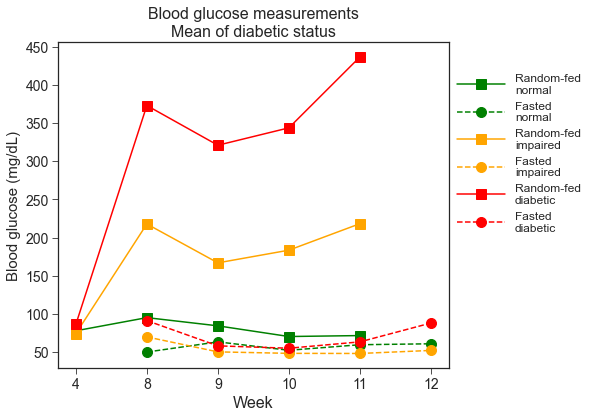

In [262]:
# Random 
nbg = obs.loc[(obs['animal'].isin(normal)) & (obs['BG type'] == 'RBG') & (obs['BG'].notna())]
normal_rbgs = nbg.groupby(by='week').mean()['BG']
ibg = obs.loc[(obs['animal'].isin(impaired)) & (obs['BG type'] == 'RBG') & (obs['BG'].notna())]
impaired_rbgs = ibg.groupby(by='week').mean()['BG']
dbg = obs.loc[(obs['animal'].isin(diabetic)) & (obs['BG type'] == 'RBG') & (obs['BG'].notna())]
diabetic_rbgs = dbg.groupby(by='week').mean()['BG']
# Fasted
nbg = obs.loc[(obs['animal'].isin(normal)) & (obs['BG type'] == 'FBG') & (obs['BG'].notna())]
normal_fbgs = nbg.groupby(by='week').mean()['BG']
ibg = obs.loc[(obs['animal'].isin(impaired)) & (obs['BG type'] == 'FBG') & (obs['BG'].notna())]
impaired_fbgs = ibg.groupby(by='week').mean()['BG']
dbg = obs.loc[(obs['animal'].isin(diabetic)) & (obs['BG type'] == 'FBG') & (obs['BG'].notna())]
diabetic_fbgs = dbg.groupby(by='week').mean()['BG']

plt.style.use('seaborn-ticks')

rbg_weeks = ['4','8','9','10','11']
fbg_weeks = ['8','9','10','11','12']
plt.plot(rbg_weeks, normal_rbgs  ,   's-',  label='Random-fed\nnormal',   ms=10, c='green',  )
plt.plot(fbg_weeks, normal_fbgs  ,   'o--', label='Fasted\nnormal',       ms=10, c='green',  )
plt.plot(rbg_weeks, impaired_rbgs, 's-',  label='Random-fed\nimpaired', ms=10, c='orange', )
plt.plot(fbg_weeks, impaired_fbgs, 'o--', label='Fasted\nimpaired',     ms=10, c='orange', )
plt.plot(rbg_weeks, diabetic_rbgs, 's-',  label='Random-fed\ndiabetic', ms=10, c='red',    )
plt.plot(fbg_weeks, diabetic_fbgs, 'o--', label='Fasted\ndiabetic',     ms=10, c='red',    )

plt.legend(loc=(1.01, 0.4), handlelength=4, fontsize=12)
plt.gcf().set_size_inches((7, 6))
plt.xticks(ticks=[0,1,2,3,4,5], fontsize=14)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Blood glucose (mg/dL)', fontsize=15)
plt.yticks(fontsize=14)
plt.title('Blood glucose measurements\nMean of diabetic status', fontsize=16)